In [1]:
import Parity_Data_Generator
import numpy as np
from newESN import ESN
import time

N = 4000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)

In [2]:
def runSomeConfigs(spectral_rad, leak_r, d_t, train_b, test_b, train_p, test_p, n_neurons):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    # z-transformation
    scale = 1/np.std(train_b)
    shift = -np.mean(train_b)/np.std(train_b)
#     print("Scale:",scale," shift:",shift)

    nParityESN = ESN(neurons=n_neurons,
                          inputs=1,  
                          leak_rate= leak_r,   # adjust leak_rate
                          spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                          dt= d_t,
                          sparsity=0.95,
                          noise=0.01,
                          input_scale=scale,
                          input_shift=shift)
#     print("Trainingerror:", nParityESN.train(train_b, train_p))
    nParityESN.train(train_b, train_p)
    pred_test = nParityESN.predict(test_b)

    predictedParity = pred_test 
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_p) ** 2))
    print(test_error)
    return test_error



In [3]:
def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
#     train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_parity, test_parity


In [19]:
trials = 10
# n_neurons_slow = [200,300,400,500]
n_neurons_slow = [300]

delta_t = [0.1]

l_rate = np.linspace(0.1, 1.5, num=10)
# l_rate =[0.2]
# l_rate = [0.1,0.2,0.3]

# sp_rad = np.linspace(0.9, 1.0, num=5)
sp_rad = np.linspace(0.1, 2, num=10)
# sp_rad = [0.8]


run_time = time.time()
iterations, iterationcount = trials*len(n_neurons_slow)*len(sp_rad)*len(l_rate)*len(delta_t), 0

delta_t_error = []
for dt in delta_t:
    neurons_slow_error = []
    for current_slow_neurons in n_neurons_slow:
        all_errors = [{} for _ in range(trials)] # empty dict
        for trial in range(trials):
            errors = []
            # produce training and testing data
            train_bits, test_bits, train_parity, test_parity = produceTrainingData(iterationcount)
            for l in l_rate:
                for s in sp_rad:
                    print("Neurons:", current_slow_neurons,"Leak-rate:",l,"Spectral-radius:",s,"Delta_t:",dt)
                    errors.append(runSomeConfigs(s,l,dt, train_bits, test_bits, train_parity, test_parity, current_slow_neurons))
                    iterationcount = iterationcount + 1
                    print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
            ## Save leak-rate,spectral-radius and error in dictionary
            all_errors[trial] = errors

        ### Average errors
        errors_averaged_over_trials = np.zeros(100)
        for i in range(len(all_errors)):
            e = all_errors[i]
            errors_averaged_over_trials = np.add(errors_averaged_over_trials, np.array(e))
        errors_averaged_over_trials = np.divide(errors_averaged_over_trials, trials)

        neurons_slow_error.append(errors_averaged_over_trials)
    
    delta_t_error.append(neurons_slow_error)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.1


C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


Testing error
0.39234972248
--- Progress: 0.10% --- 0.23 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.311111111111 Delta_t: 0.1
Testing error
0.514445848698
--- Progress: 0.20% --- 0.47 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.522222222222 Delta_t: 0.1
Testing error
0.54270640567
--- Progress: 0.30% --- 0.70 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.733333333333 Delta_t: 0.1
Testing error
0.556786255739
--- Progress: 0.40% --- 0.93 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.944444444444 Delta_t: 0.1
Testing error
0.539444067946
--- Progress: 0.50% --- 1.15 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 1.15555555556 Delta_t: 0.1
Testing error
0.546904888408
--- Progress: 0.60% --- 1.38 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 1.36666666667 Delta_t: 0.1
Testing error
0.554039445811
--- Progress: 0.70% --- 1.61 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 1.57777777778 Delta_t: 0.1
Test

In [20]:
import pickle
#### Save Data
with open('dataNewESNaverage10largeValuesAndScalingandShift.p', 'wb') as outputFile:
    pickle.dump(delta_t_error, outputFile)
    pickle.dump(neurons_slow_error, outputFile)
    pickle.dump(n_neurons_slow, outputFile)
    pickle.dump(delta_t, outputFile)
    pickle.dump(trials, outputFile)
    pickle.dump(l_rate, outputFile)
    pickle.dump(sp_rad, outputFile)
#### Load Data
# with open('dataNewESNTimescale50average10extendedSradLRate.p', 'rb') as inputFile:
#     delta_t_error = pickle.load(inputFile)
#     neurons_slow_error = pickle.load(inputFile)
#     n_neurons_slow = pickle.load(inputFile)
#     delta_t = pickle.load(inputFile)
#     trials = pickle.load(inputFile)
#     l_rate = pickle.load(inputFile)
#     sp_rad = pickle.load(inputFile)

Best Error: 0.179396226326
with leak-rate 0.722222222222
with sp_rad 1.36666666667


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


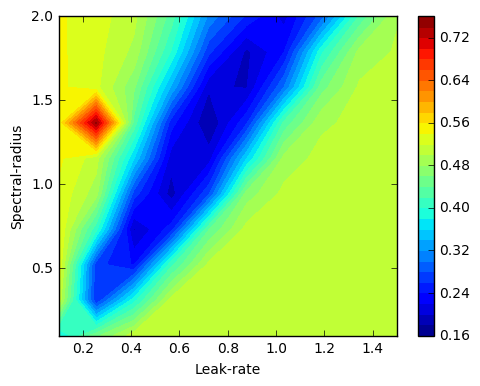

In [28]:
### Different delta_t
import numpy as np
from matplotlib import pyplot
%matplotlib inline
# print(delta_t_error[0])
xx, yy = np.meshgrid(l_rate, sp_rad)
pyplot.figure(figsize=(12,14))
for p in range(len(delta_t)):
    pyplot.subplot(3,2,p+1)
    pyplot.contourf(xx,
                    yy,delta_t_error[p][0].reshape(10,10).T, 30)
#     pyplot.title("slowESN error delta 0.1 averaged over 10 trials")
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()
# print(delta_t_error[0][0].reshape(10,10).T)

# print(np.argmin(delta_t_error[0][0].reshape(10,10).T))
# print(delta_t_error[0][0].reshape(10,10).T[9][5])
print("Best Error:", np.min(delta_t_error[0]))
print("with leak-rate",l_rate[np.argmin(delta_t_error[0][0].reshape(10,10).T)%10])
print("with sp_rad",sp_rad[np.argmin(delta_t_error[0][0].reshape(10,10).T)/10])

In [6]:
#### Get Parameters from a good performing slowESN
train_bits, test_bits, train_parity, test_parity = produceTrainingData(42)
# z-transformation
scale = 1/np.std(train_bits)
shift = -np.mean(train_bits)/np.std(train_bits)
nParityESN = ESN(neurons=300,
                          inputs=1,  
                          leak_rate= 0.72,   # adjust leak_rate
                          spectral_radius=1.36,  # high spectral rad is better (high fluctuations 0->1->0)
                          dt= 0.1,
                          sparsity=0.95,
                          noise=0.01,
                          input_scale=scale,
                          input_shift=shift)

nParityESN.train(train_bits, train_parity)

C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


In [30]:
##### Create Training Data for fastESN with output from slowESN
start_time = time.time()

new_rng = np.random.RandomState(1337)
new_N= 1500
# new_bits, new_parity, new_target = Parity_Data_Generator.generateParityData(new_N, new_n, 
#                                                                             timescale=timescale,randomstate=new_rng)

# # Divide in training and test data
# traintest_cutoff = int(np.ceil(0.7 * len(bits)))
# new_train_bits, new_test_bits = new_bits[:traintest_cutoff], new_bits[traintest_cutoff:]
# # new_train_parity, new_test_parity = new_parity[:traintest_cutoff], new_parity[traintest_cutoff:]
# new_train_targets, new_test_targets = new_target[:traintest_cutoff], new_target[traintest_cutoff:]

# train_predicted_parity = nParityESN.predict(new_train_bits)
# test_predicted_parity = nParityESN.predict(new_test_bits)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [4]:
#### FastESN ####
def runSomeFastConfigs(spectral_rad, leak_r, d_t, train_parity, test_parity, 
                       train_targets, test_targets, num_neurons=100):
    # z-transformation
    fast_scale = 1/np.std(train_parity)
    fast_shift = -np.mean(train_parity)/np.std(train_parity)
    outputESN = ESN(neurons=num_neurons,
                              inputs=1,
                              spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                              leak_rate= leak_r,   # adjust leak_rate
                              dt= d_t,
                              sparsity=0.95,
                              noise=0.01,
                              input_scale=fast_scale,
                              input_shift=fast_shift)
        # print(np.shape(bits),np.shape(parity),np.shape(target))
    outputESN.train(train_parity, train_targets)
    pred_test = outputESN.predict(test_parity)
        
    print("Testing error")
    test_error = np.sqrt(np.mean((pred_test - test_targets) ** 2))
    print(test_error)
    return test_error

def produceFastTrainingData(randomState):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(randomState))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    
    train_predicted_parity = nParityESN.predict(train_bits)
    test_predicted_parity = nParityESN.predict(test_bits)
    
    return train_predicted_parity, test_predicted_parity, train_targets, test_targets

In [34]:
new_trials = 10
n_neurons_fast = 50
# num_neurons_fast = [100]
delta_t_fast = [0.1]
l_rate_fast = np.linspace(0.1, 1.5, num=10)
sp_rad_fast = np.linspace(0.1, 2, num=10)

run_time = time.time()
iterations, iterationcount = new_trials*len(sp_rad_fast)*len(l_rate_fast)*len(delta_t_fast), 0

delta_t_errors_fast = []
for dt_fast in delta_t_fast:
    all_errors_fast = [{} for _ in range(new_trials)]
    for newtrial in range(new_trials):
        errors = []

        new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceFastTrainingData(iterationcount)

        for l in l_rate_fast:
            for s in sp_rad_fast:
                print("Neurons:", n_neurons_fast, "Leak-rate:", l, "Spectral-radius:", s,"Delta_t:",dt_fast)
                errors.append(runSomeFastConfigs(s,l,dt_fast,new_train_parity, new_test_parity, new_train_targets, new_test_targets,n_neurons_fast))
                iterationcount = iterationcount + 1
                print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
        ## Save leak-rate,spectral-radius and error in dictionary
        all_errors_fast[newtrial] = errors

    ### Average errors
    fast_errors_averaged_over_trials = np.zeros(100)
    for i in range(len(all_errors_fast)):
        e = all_errors_fast[i]
        fast_errors_averaged_over_trials = np.add(fast_errors_averaged_over_trials, np.array(e))

    fast_errors_averaged_over_trials = np.divide(fast_errors_averaged_over_trials, new_trials)
    
    delta_t_errors_fast.append(fast_errors_averaged_over_trials)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.1


C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


Testing error
0.288580808641
--- Progress: 0.10% --- 0.29 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.311111111111 Delta_t: 0.1
Testing error
0.328305153044
--- Progress: 0.20% --- 0.37 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.522222222222 Delta_t: 0.1
Testing error
0.330104239176
--- Progress: 0.30% --- 0.47 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.733333333333 Delta_t: 0.1
Testing error
0.262197857405
--- Progress: 0.40% --- 0.55 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.944444444444 Delta_t: 0.1
Testing error
0.301448621491
--- Progress: 0.50% --- 0.64 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 1.15555555556 Delta_t: 0.1
Testing error
0.387698766444
--- Progress: 0.60% --- 0.72 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 1.36666666667 Delta_t: 0.1
Testing error
0.207739850163
--- Progress: 0.70% --- 0.81 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 1.57777777778 Delta_t: 0.1
Testing e

In [35]:
import pickle
#### Save Data
with open('dataNewFastDelta_t01ErrorsAveraged10largeValuesandScaleAndShift.p','wb') as outputFile:
    pickle.dump(delta_t_errors_fast,outputFile)
    pickle.dump(fast_errors_averaged_over_trials, outputFile)
    pickle.dump(n_neurons_fast, outputFile)
    pickle.dump(delta_t_fast, outputFile)
    pickle.dump(new_trials, outputFile)
    pickle.dump(l_rate_fast, outputFile)
    pickle.dump(sp_rad_fast, outputFile)
#### Load Data
# with open('dataNewFastDelta_t01ErrorsAveraged10.p', 'rb') as inputFile:
#     delta_t_errors_fast = pickle.load(inputFile)
#     fast_errors_averaged_over_trials = pickle.load(inputFile)
#     n_neurons_fast = pickle.load(inputFile)
#     delta_t_fast = pickle.load(inputFile)
#     new_trials = pickle.load(inputFile)
#     l_rate_fast = pickle.load(inputFile)
#     sp_rad_fast = pickle.load(inputFile)

[0.1]
Best Error: 0.129914958787
with leak-rate 1.5
with sp_rad 1.57777777778


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


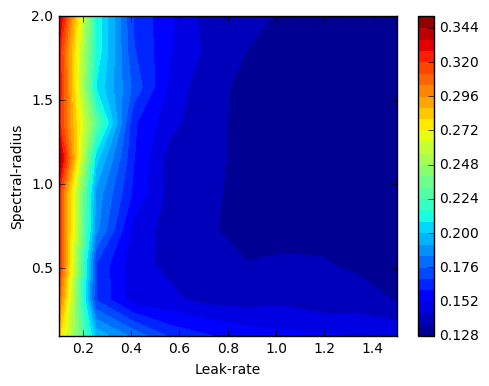

In [36]:
### Different delta_t

from matplotlib import pyplot
import numpy as np
%matplotlib inline
print(delta_t_fast)
xx, yy = np.meshgrid(l_rate_fast, sp_rad_fast)
pyplot.figure(figsize=(12,14))
for p in range(len(delta_t_fast)):
    pyplot.subplot(3,2,p+1)
    pyplot.contourf(xx,
                    yy,delta_t_errors_fast[p].reshape(10,10).T, 30)
#     pyplot.title("Fast ESN trained using best slow ESN averaged 10")
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()
print("Best Error:", np.min(delta_t_errors_fast[0]))
print("with leak-rate",l_rate_fast[np.argmin(delta_t_errors_fast[0].reshape(10,10).T)%10])
print("with sp_rad",sp_rad_fast[np.argmin(delta_t_errors_fast[0].reshape(10,10).T)/10])

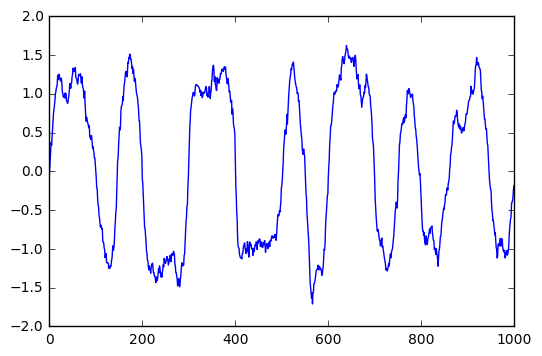

In [37]:
temp = nParityESN.predict(train_parity)
temp2 = (temp - temp.mean())/temp.std()
pyplot.plot(temp2[-1000:,::10])

C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:
C:\Users\Kevin\Documents\Python-projects\BA-ESN\newESN.py:54: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if readout_weights == None:


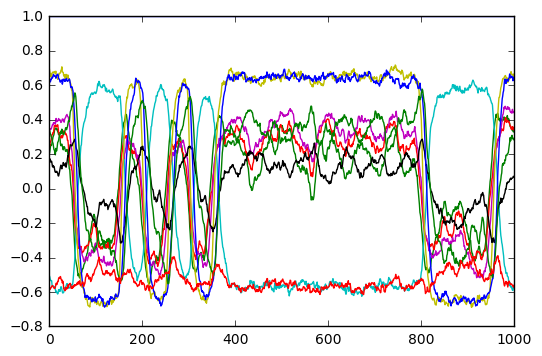

In [9]:
from matplotlib import pyplot
%matplotlib inline
new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceFastTrainingData(222)
# z-transformation
fast_scale = 1/np.std(new_train_parity)
fast_shift = -np.mean(new_train_parity)/np.std(new_train_parity)
fastESN = ESN(neurons=50,
                              inputs=1,
                              spectral_radius=2.0,  # high spectral rad is better (high fluctuations 0->1->0)
                              leak_rate= 1.5,   # adjust leak_rate
                              dt= 0.1,
                              sparsity=0.95,
                              noise=0.01,
                              input_scale=scale,
                              input_shift=shift)

fastESN.train(new_train_parity, new_train_targets)
fasttemp = fastESN.predict(new_test_parity, np.eye(50))
pyplot.plot(fasttemp[-1000:,::5])

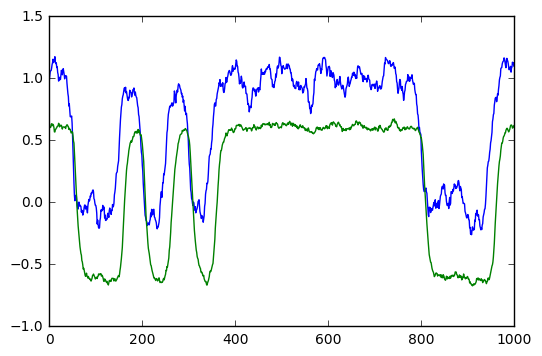

In [10]:
pyplot.plot(new_test_parity[-1000:])
pyplot.plot(fasttemp[-1000:,34])